In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/data_0-1.csv', name='data_0-1.csv', size=151, modificationTime=1739032568000),
 FileInfo(path='dbfs:/FileStore/tables/data_0.csv', name='data_0.csv', size=151, modificationTime=1739029178000),
 FileInfo(path='dbfs:/FileStore/tables/data_1.csv', name='data_1.csv', size=153, modificationTime=1739032568000),
 FileInfo(path='dbfs:/FileStore/tables/data_2.csv', name='data_2.csv', size=151, modificationTime=1739032568000),
 FileInfo(path='dbfs:/FileStore/tables/data_3.csv', name='data_3.csv', size=153, modificationTime=1739032569000),
 FileInfo(path='dbfs:/FileStore/tables/data_4.csv', name='data_4.csv', size=154, modificationTime=1739032569000),
 FileInfo(path='dbfs:/FileStore/tables/data_5.csv', name='data_5.csv', size=155, modificationTime=1739032540000),
 FileInfo(path='dbfs:/FileStore/tables/data_6.csv', name='data_6.csv', size=155, modificationTime=1739032569000),
 FileInfo(path='dbfs:/FileStore/tables/data_7.csv', name='data_7.csv', size=

In [0]:
from pyspark.sql.functions import col, sum, avg, weekofyear
from pyspark.sql.functions import to_date
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import lpad
from pyspark.sql.functions import round
from pyspark.sql.functions import col, year, month, weekofyear, when

Celem opracowania jest analiza szeregow czasowych z wykorzystaniem Spark. Analiza obejmuje:
- 


- Calculation of weekly, monthly, seasonal and annual average PRECTOT, PS, TS using the groupBy function.
- Calculating weekly average for PRCTOT, PS, TS using the Window function.
- Calculation of weekly, monthly, seasonal standard deviation for PRECTOT, TS, PS and finding 3 states with the greatest and least variability.
- Calculation of how many days there were without precipitation for each fips in a given year.
- Calculation of how many consecutive days without precipitation there were in each fips in each year.
- Moving average analysis for county 4027 which had the longest break in precipitation of 92 days.
- County 48245 in Texas has the largest weekly standard deviation of PRECTOT precipitation. Calculating how precipitation has varied from day to day in this county.
- Calculate the total precipitation (PRECTOT) for each season in a given year and determine how total precipitation varied throughout the year depending on the season.
- Calculate the average precipitation (PRECTOT) for each season in a given year and determine how average precipitation varied between seasons.
- Identification of days with precipitation anomalies where precipitation anomalies occur, in which precipitation is greater than 3 standard deviations above the mean
- Detection of sudden temperature jumps (TS). Calculation of the temperature change (TS) from the previous day.
- Removing NAN
- Counting how many score occurrences there are in each class
- Counting in which state class 4 and 5 appears most often
- DataFrame weather and soil connection based on column 'fips' and 'date'

Time series contain daily weather data and drought class for every county in the US for 2017 and 2018

In [0]:
weather = spark.read.csv("dbfs:/FileStore/tables/validation_timeseries__1_.csv", header=True, inferSchema=True)

In [0]:
soil = spark.read.csv("dbfs:/FileStore/tables/soil_data.csv", header=True, inferSchema=True)

In [0]:
weather.printSchema()

root
 |-- fips: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- PRECTOT: double (nullable = true)
 |-- PS: double (nullable = true)
 |-- QV2M: double (nullable = true)
 |-- T2M: double (nullable = true)
 |-- T2MDEW: double (nullable = true)
 |-- T2MWET: double (nullable = true)
 |-- T2M_MAX: double (nullable = true)
 |-- T2M_MIN: double (nullable = true)
 |-- T2M_RANGE: double (nullable = true)
 |-- TS: double (nullable = true)
 |-- WS10M: double (nullable = true)
 |-- WS10M_MAX: double (nullable = true)
 |-- WS10M_MIN: double (nullable = true)
 |-- WS10M_RANGE: double (nullable = true)
 |-- WS50M: double (nullable = true)
 |-- WS50M_MAX: double (nullable = true)
 |-- WS50M_MIN: double (nullable = true)
 |-- WS50M_RANGE: double (nullable = true)
 |-- score: double (nullable = true)



In [0]:
num_rows = weather.count()
num_cols = len(weather.columns)
print(f"Liczba wierszy: {num_rows}, Liczba kolumn: {num_cols}")

Liczba wierszy: 2268840, Liczba kolumn: 21


In [0]:
Checking Nan

In [0]:

nan_counts = weather.select([sum(col(c).isNull().cast("int")).alias(c) for c in weather.columns])


nan_counts.show()

+----+----+-------+---+----+---+------+------+-------+-------+---------+---+-----+---------+---------+-----------+-----+---------+---------+-----------+-------+
|fips|date|PRECTOT| PS|QV2M|T2M|T2MDEW|T2MWET|T2M_MAX|T2M_MIN|T2M_RANGE| TS|WS10M|WS10M_MAX|WS10M_MIN|WS10M_RANGE|WS50M|WS50M_MAX|WS50M_MIN|WS50M_RANGE|  score|
+----+----+-------+---+----+---+------+------+-------+-------+---------+---+-----+---------+---------+-----------+-----+---------+---------+-----------+-------+
|   0|   0|      0|  0|   0|  0|     0|     0|      0|      0|        0|  0|    0|        0|        0|          0|    0|        0|        0|          0|1945608|
+----+----+-------+---+----+---+------+------+-------+-------+---------+---+-----+---------+---------+-----------+-----+---------+---------+-----------+-------+



Removing columns that are not subject to analysis.

In [0]:
column_names = weather.columns


print(column_names)

['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'score']


In [0]:
column_names = soil.columns


print(column_names)

['fips', 'lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE', 'aspectS', 'aspectW', 'aspectUnknown', 'WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND', 'CULT_LAND', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']


In [0]:
del_col_weather = ['QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']

In [0]:
del_col_soil = [ 'elevation', 'slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE', 'aspectS', 'aspectW', 'aspectUnknown', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']

In [0]:

weather = weather.drop(*del_col_weather)


weather.show()

+----+----------+-------+------+-----+-----+
|fips|      date|PRECTOT|    PS|   TS|score|
+----+----------+-------+------+-----+-----+
|1001|2017-01-01|   32.5|100.02|14.63| null|
|1001|2017-01-02|  63.52|100.04|17.85| null|
|1001|2017-01-03|  18.82| 99.69|14.06|  2.0|
|1001|2017-01-04|   0.01|100.02| 8.08| null|
|1001|2017-01-05|   0.01| 99.89| 5.85| null|
|1001|2017-01-06|  19.85|100.34| 0.42| null|
|1001|2017-01-07|   0.06|101.59|-7.05| null|
|1001|2017-01-08|    0.0|102.36|-8.36| null|
|1001|2017-01-09|    0.0|101.98|-3.05| null|
|1001|2017-01-10|   0.02|101.13| 5.81|  2.0|
|1001|2017-01-11|   0.33|100.81|14.21| null|
|1001|2017-01-12|   0.09|101.03|15.54| null|
|1001|2017-01-13|    0.0| 101.5| 15.8| null|
|1001|2017-01-14|    0.0|101.42|14.44| null|
|1001|2017-01-15|    0.0|100.95|14.23| null|
|1001|2017-01-16|    0.0|100.73|15.71| null|
|1001|2017-01-17|   0.14| 100.6| 17.1|  2.0|
|1001|2017-01-18|   0.28|100.49|17.18| null|
|1001|2017-01-19|  27.01| 99.81|17.43| null|
|1001|2017

In [0]:

soil = soil.drop(*del_col_soil)

soil.show()

+----+---------+----------+-----------------+----------------+-----------------+-----------------+----------------+-----------------+-------------------+-------------------+
|fips|      lat|       lon|         WAT_LAND|        NVG_LAND|         URB_LAND|         GRS_LAND|        FOR_LAND|      CULTRF_LAND|        CULTIR_LAND|          CULT_LAND|
+----+---------+----------+-----------------+----------------+-----------------+-----------------+----------------+-----------------+-------------------+-------------------+
|1001|32.536382| -86.64449|0.997399985790253|27.9404983520508| 0.28889998793602| 2.75027370452881|10.7147026062012| 56.2934112548828|   1.01481103897095|   57.3082237243652|
|1005| 31.87067|-85.405456|              0.0|             0.0|0.414599984884262| 2.22560167312622|22.9528388977051| 72.5788040161133|   1.82815897464752|   74.4069595336914|
|1003|30.659218|-87.746067|              0.0|             0.0| 3.50099992752075|  4.9724555015564|28.6859912872314| 59.84363937377

In [0]:
columns_to_round = ['NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND', 'CULT_LAND']

In [0]:

for col in columns_to_round:
    soil = soil.withColumn(col, round(soil[col], 1))


soil.show()

+----+---------+----------+-----------------+--------+--------+--------+--------+-----------+-----------+---------+
|fips|      lat|       lon|         WAT_LAND|NVG_LAND|URB_LAND|GRS_LAND|FOR_LAND|CULTRF_LAND|CULTIR_LAND|CULT_LAND|
+----+---------+----------+-----------------+--------+--------+--------+--------+-----------+-----------+---------+
|1001|32.536382| -86.64449|0.997399985790253|    27.9|     0.3|     2.8|    10.7|       56.3|        1.0|     57.3|
|1005| 31.87067|-85.405456|              0.0|     0.0|     0.4|     2.2|    23.0|       72.6|        1.8|     74.4|
|1003|30.659218|-87.746067|              0.0|     0.0|     3.5|     5.0|    28.7|       59.8|        3.0|     62.8|
|1007|33.015893|-87.127148|              0.0|     0.0|     0.2|     8.7|    89.2|        1.9|        0.0|      1.9|
|1009|33.977448|-86.567246|              0.0|     0.0|     1.0|     8.6|    88.5|        1.9|        0.0|      1.9|
|1011|32.101759|-85.717261|              0.0|     0.0|     0.3|     8.8|

Change the date format and specify seasons.

In [0]:
weather = weather.withColumn("year", year(col("date"))) \
                 .withColumn("month", month(col("date"))) \
                 .withColumn("week", weekofyear(col("date"))) \
                 .withColumn("season",
                             when(col("month").isin([12, 1, 2]), "Winter")
                             .when(col("month").isin([3, 4, 5]), "Spring")
                             .when(col("month").isin([6, 7, 8]), "Summer")
                             .otherwise("Fall"))

weather.show()

+----+----------+-------+------+-----+-----+----+-----+----+------+
|fips|      date|PRECTOT|    PS|   TS|score|year|month|week|season|
+----+----------+-------+------+-----+-----+----+-----+----+------+
|1001|2017-01-01|   32.5|100.02|14.63| null|2017|    1|  52|Winter|
|1001|2017-01-02|  63.52|100.04|17.85| null|2017|    1|   1|Winter|
|1001|2017-01-03|  18.82| 99.69|14.06|  2.0|2017|    1|   1|Winter|
|1001|2017-01-04|   0.01|100.02| 8.08| null|2017|    1|   1|Winter|
|1001|2017-01-05|   0.01| 99.89| 5.85| null|2017|    1|   1|Winter|
|1001|2017-01-06|  19.85|100.34| 0.42| null|2017|    1|   1|Winter|
|1001|2017-01-07|   0.06|101.59|-7.05| null|2017|    1|   1|Winter|
|1001|2017-01-08|    0.0|102.36|-8.36| null|2017|    1|   1|Winter|
|1001|2017-01-09|    0.0|101.98|-3.05| null|2017|    1|   2|Winter|
|1001|2017-01-10|   0.02|101.13| 5.81|  2.0|2017|    1|   2|Winter|
|1001|2017-01-11|   0.33|100.81|14.21| null|2017|    1|   2|Winter|
|1001|2017-01-12|   0.09|101.03|15.54| null|2017

Added information about states.

In [0]:

weather = weather.withColumn(
    "fips_padded", 
    F.lpad(F.col("fips").cast("string"), 5, "0")  
)


weather = weather.withColumn(
    "state_code", 
    F.col("fips_padded").substr(1, 2)  
)

In [0]:
weather.show(3)

+----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+
|fips|      date|PRECTOT|    PS|   TS|score|year|month|week|season|fips_padded|state_code|
+----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+
|1001|2017-01-01|   32.5|100.02|14.63| null|2017|    1|  52|Winter|      01001|        01|
|1001|2017-01-02|  63.52|100.04|17.85| null|2017|    1|   1|Winter|      01001|        01|
|1001|2017-01-03|  18.82| 99.69|14.06|  2.0|2017|    1|   1|Winter|      01001|        01|
+----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+
only showing top 3 rows



In [0]:

state_column = F.when(F.col("state_code") == "01", "Alabama") \
    .when(F.col("state_code") == "02", "Alaska") \
    .when(F.col("state_code") == "04", "Arizona") \
    .when(F.col("state_code") == "05", "Arkansas") \
    .when(F.col("state_code") == "06", "Kalifornia") \
    .when(F.col("state_code") == "08", "Kolorado") \
    .when(F.col("state_code") == "09", "Connecticut") \
    .when(F.col("state_code") == "10", "Delaware") \
    .when(F.col("state_code") == "11", "Dystrykt Kolumbii") \
    .when(F.col("state_code") == "12", "Floryda") \
    .when(F.col("state_code") == "13", "Georgia") \
    .when(F.col("state_code") == "15", "Hawaje") \
    .when(F.col("state_code") == "16", "Idaho") \
    .when(F.col("state_code") == "17", "Illinois") \
    .when(F.col("state_code") == "18", "Indiana") \
    .when(F.col("state_code") == "19", "Iowa") \
    .when(F.col("state_code") == "20", "Kansas") \
    .when(F.col("state_code") == "21", "Kentucky") \
    .when(F.col("state_code") == "22", "Luizjana") \
    .when(F.col("state_code") == "23", "Maine") \
    .when(F.col("state_code") == "24", "Maryland") \
    .when(F.col("state_code") == "25", "Massachusetts") \
    .when(F.col("state_code") == "26", "Michigan") \
    .when(F.col("state_code") == "27", "Minnesota") \
    .when(F.col("state_code") == "28", "Mississippi") \
    .when(F.col("state_code") == "29", "Missouri") \
    .when(F.col("state_code") == "30", "Montana") \
    .when(F.col("state_code") == "31", "Nebraska") \
    .when(F.col("state_code") == "32", "Nevada") \
    .when(F.col("state_code") == "33", "New Hampshire") \
    .when(F.col("state_code") == "34", "New Jersey") \
    .when(F.col("state_code") == "35", "Nowy Meksyk") \
    .when(F.col("state_code") == "36", "Nowy Jork") \
    .when(F.col("state_code") == "37", "Karolina Północna") \
    .when(F.col("state_code") == "38", "Dakota Północna") \
    .when(F.col("state_code") == "39", "Ohio") \
    .when(F.col("state_code") == "40", "Oklahoma") \
    .when(F.col("state_code") == "41", "Oregon") \
    .when(F.col("state_code") == "42", "Pensylwania") \
    .when(F.col("state_code") == "44", "Rhode Island") \
    .when(F.col("state_code") == "45", "Karolina Południowa") \
    .when(F.col("state_code") == "46", "Dakota Południowa") \
    .when(F.col("state_code") == "47", "Tennessee") \
    .when(F.col("state_code") == "48", "Teksas") \
    .when(F.col("state_code") == "49", "Utah") \
    .when(F.col("state_code") == "50", "Vermont") \
    .when(F.col("state_code") == "51", "Wirginia") \
    .when(F.col("state_code") == "53", "Waszyngton") \
    .when(F.col("state_code") == "54", "Wirginia Zachodnia") \
    .when(F.col("state_code") == "55", "Wisconsin") \
    .when(F.col("state_code") == "56", "Wyoming") \
    .otherwise(F.lit("Unknown"))

In [0]:

weather = weather.withColumn("state", state_column)

In [0]:
weather.show(3)

+----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+-------+
|fips|      date|PRECTOT|    PS|   TS|score|year|month|week|season|fips_padded|state_code|  state|
+----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+-------+
|1001|2017-01-01|   32.5|100.02|14.63| null|2017|    1|  52|Winter|      01001|        01|Alabama|
|1001|2017-01-02|  63.52|100.04|17.85| null|2017|    1|   1|Winter|      01001|        01|Alabama|
|1001|2017-01-03|  18.82| 99.69|14.06|  2.0|2017|    1|   1|Winter|      01001|        01|Alabama|
+----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+-------+
only showing top 3 rows



1. Calculation of weekly, monthly, seasonal and annual average PRECTOT, PS, TS using the groupBy function.

In [0]:
weather = weather.withColumn("state_code", F.substring(F.col("fips_padded"), 1, 2))

In [0]:

df_weekly_avg = weather.groupBy("fips", "state", "year", "week") \
    .agg(F.avg("PRECTOT").alias("weekly_avg_PRECTOT"),
         F.avg("PS").alias("weekly_avg_PS"),
         F.avg("TS").alias("weekly_avg_TS"))


df_monthly_avg = weather.groupBy("fips", "year", "month") \
    .agg(F.avg("PRECTOT").alias("monthly_avg_PRECTOT"),
         F.avg("PS").alias("monthly_avg_PS"),
         F.avg("TS").alias("monthly_avg_TS"))


df_seasonal_avg = weather.groupBy("fips", "year", "season") \
    .agg(F.avg("PRECTOT").alias("seasonal_avg_PRECTOT"),
         F.avg("PS").alias("seasonal_avg_PS"),
         F.avg("TS").alias("seasonal_avg_TS"))


df_annual_avg = weather.groupBy("fips", "year") \
    .agg(F.avg("PRECTOT").alias("annual_avg_PRECTOT"),
         F.avg("PS").alias("annual_avg_PS"),
         F.avg("TS").alias("annual_avg_TS"))


df_weekly_avg.show(3)
# df_monthly_avg.show()
# df_seasonal_avg.show()
# df_annual_avg.show()

+----+-------+----+----+------------------+------------------+------------------+
|fips|  state|year|week|weekly_avg_PRECTOT|     weekly_avg_PS|     weekly_avg_TS|
+----+-------+----+----+------------------+------------------+------------------+
|1001|Alabama|2017|  16|1.8314285714285714|100.17714285714284| 20.62285714285714|
|1001|Alabama|2017|  27|2.2385714285714284|100.27000000000001|26.815714285714286|
|1005|Alabama|2018|  14|1.2542857142857142|100.21142857142857|15.875714285714286|
+----+-------+----+----+------------------+------------------+------------------+
only showing top 3 rows



In [0]:
df_weekly_avg = df_weekly_avg.orderBy("fips","state", "year", "week")

df_weekly_avg.show(3)

+----+-------+----+----+-------------------+------------------+------------------+
|fips|  state|year|week| weekly_avg_PRECTOT|     weekly_avg_PS|     weekly_avg_TS|
+----+-------+----+----+-------------------+------------------+------------------+
|1001|Alabama|2017|   1| 14.610000000000001|100.56142857142858| 4.407142857142858|
|1001|Alabama|2017|   2|0.06285714285714286|            101.26|10.997142857142858|
|1001|Alabama|2017|   3| 14.821428571428571| 99.72714285714287| 16.98714285714286|
+----+-------+----+----+-------------------+------------------+------------------+
only showing top 3 rows



2. Calculating weekly average for PRCTOT, PS, TS using the Window function.

In [0]:

columns_to_avg = ["PRECTOT", "TS", "PS"]


windowSpec = Window.partitionBy("fips", "year", "week")

df_with_weekly_avg1 = weather
for col in columns_to_avg:
    avg_col_name = f"weekly_avg_{col}"  
    df_with_weekly_avg1 = df_with_weekly_avg1.withColumn(
        avg_col_name, F.avg(col).over(windowSpec)
    )

df_with_weekly_avg1.select("fips", "date", "state","year", "week", *[f"weekly_avg_{col}" for col in columns_to_avg]).show(10)

+----+----------+-------+----+----+-------------------+------------------+-----------------+
|fips|      date|  state|year|week| weekly_avg_PRECTOT|     weekly_avg_TS|    weekly_avg_PS|
+----+----------+-------+----+----+-------------------+------------------+-----------------+
|1001|2017-01-09|Alabama|2017|   2|0.06285714285714286|10.997142857142858|           101.26|
|1001|2017-01-10|Alabama|2017|   2|0.06285714285714286|10.997142857142858|           101.26|
|1001|2017-01-11|Alabama|2017|   2|0.06285714285714286|10.997142857142858|           101.26|
|1001|2017-01-12|Alabama|2017|   2|0.06285714285714286|10.997142857142858|           101.26|
|1001|2017-01-13|Alabama|2017|   2|0.06285714285714286|10.997142857142858|           101.26|
|1001|2017-01-14|Alabama|2017|   2|0.06285714285714286|10.997142857142858|           101.26|
|1001|2017-01-15|Alabama|2017|   2|0.06285714285714286|10.997142857142858|           101.26|
|1001|2017-01-16|Alabama|2017|   3| 14.821428571428571| 16.98714285714

3. Calculation of weekly, monthly, seasonal standard deviation for PRECTOT, TS, PS and finding 3 states with the greatest and least variability.

In [0]:

df_std_weekly = weather.groupBy("fips", "state" ,"year", "week").agg(
    F.stddev("PRECTOT").alias("std_weekly_PRECTOT"),
    F.stddev("PS").alias("std_weekly_PS"),
    F.stddev("TS").alias("std_weekly_TS")
)

df_std_monthly = weather.groupBy("fips", "state", "year", "month").agg(
    F.stddev("PRECTOT").alias("std_monthly_PRECTOT"),
    F.stddev("PS").alias("std_monthly_PS"),
    F.stddev("TS").alias("std_monthly_TS")
)

df_std_seasonal = weather.groupBy("fips","state" ,"year", "season").agg(
    F.stddev("PRECTOT").alias("std_seasonal_PRECTOT"),
    F.stddev("PS").alias("std_seasonal_PS"),
    F.stddev("TS").alias("std_seasonal_TS")
)

df_std_annual = weather.groupBy("fips","state", "year").agg(
    F.stddev("PRECTOT").alias("std_annual_PRECTOT"),
    F.stddev("PS").alias("std_annual_PS"),
    F.stddev("TS").alias("std_annual_TS")
)


df_std_annual.show(4)

+----+----------+----+------------------+-------------------+-----------------+
|fips|     state|year|std_annual_PRECTOT|      std_annual_PS|    std_annual_TS|
+----+----------+----+------------------+-------------------+-----------------+
|1015|   Alabama|2018| 8.224137113581193|0.49951519021914487|9.208108992748695|
|1109|   Alabama|2018| 8.184131563522428|0.49910804379392115|8.295879514830379|
|5025|  Arkansas|2017| 8.101501910812505| 0.5857453337122497| 8.16541626212067|
|6089|Kalifornia|2017| 9.638705614137292|0.49852991773816185| 9.60182985055455|
+----+----------+----+------------------+-------------------+-----------------+
only showing top 4 rows



In [0]:
df_std_weekly.show(3)

+----+-------+----+----+------------------+-------------------+------------------+
|fips|  state|year|week|std_weekly_PRECTOT|      std_weekly_PS|     std_weekly_TS|
+----+-------+----+----+------------------+-------------------+------------------+
|1001|Alabama|2017|  16|3.9885729635690863| 0.4431972580283043| 2.389321481688295|
|1001|Alabama|2017|  27|2.8769279250120756|0.10488088481701782|0.5670642862691196|
|1005|Alabama|2018|  14|2.1148038296956146|0.36439120788096874| 2.814899981306957|
+----+-------+----+----+------------------+-------------------+------------------+
only showing top 3 rows



In [0]:
df_std_weekly_sorted = df_std_weekly.orderBy(F.col("std_weekly_PRECTOT").desc())

df_std_weekly_sorted.show(5)

+-----+------+----+----+------------------+-------------------+------------------+
| fips| state|year|week|std_weekly_PRECTOT|      std_weekly_PS|     std_weekly_TS|
+-----+------+----+----+------------------+-------------------+------------------+
|48245|Teksas|2017|  35|101.14482697503381| 0.5869371670760253|0.9320484352834278|
|48071|Teksas|2017|  35| 93.70091184696327| 0.5791208443675223| 1.127466608100191|
|48201|Teksas|2017|  34|  90.3838987978764|  0.374915863577288|1.8105326761559906|
|48473|Teksas|2017|  34| 90.07927461012169|0.35456210417117046| 2.653355467722945|
|48339|Teksas|2017|  34| 90.07927461012169|0.35456210417117046| 2.653355467722945|
+-----+------+----+----+------------------+-------------------+------------------+
only showing top 5 rows



In [0]:

top_states_weekly = df_std_weekly.groupby("state").agg(F.max("std_weekly_PRECTOT").alias("max_std_weekly_PRECTOT"))
top_states_monthly = df_std_monthly.groupby("state").agg(F.max("std_monthly_PRECTOT").alias("max_std_monthly_PRECTOT"))
top_states_seasonal = df_std_seasonal.groupby("state").agg(F.max("std_seasonal_PRECTOT").alias("max_std_seasonal_PRECTOT"))
top_states_annual = df_std_annual.groupby("state").agg(F.max("std_annual_PRECTOT").alias("max_std_annual_PRECTOT"))


top3_states_weekly = top_states_weekly.orderBy(F.desc("max_std_weekly_PRECTOT")).limit(3)
top3_states_monthly = top_states_monthly.orderBy(F.desc("max_std_monthly_PRECTOT")).limit(3)
top3_states_seasonal = top_states_seasonal.orderBy(F.desc("max_std_seasonal_PRECTOT")).limit(3)
top3_states_annual = top_states_annual.orderBy(F.desc("max_std_annual_PRECTOT")).limit(3)


print("🔹 3 Stany z największym odchyleniem standardowym PRECTOT:")
print("\n📌 Weekly:"); top3_states_weekly.show()
print("\n📌 Monthly:"); top3_states_monthly.show()
print("\n📌 Seasonal:"); top3_states_seasonal.show()
print("\n📌 Annual:"); top3_states_annual.show()

🔹 3 Stany z największym odchyleniem standardowym PRECTOT:

📌 Weekly:
+-------------------+----------------------+
|              state|max_std_weekly_PRECTOT|
+-------------------+----------------------+
|             Teksas|    101.14482697503381|
|  Karolina Północna|     79.49759175747461|
|Karolina Południowa|     72.98090203542816|
+-------------------+----------------------+


📌 Monthly:
+-------------------+-----------------------+
|              state|max_std_monthly_PRECTOT|
+-------------------+-----------------------+
|             Teksas|      64.12399338747541|
|  Karolina Północna|      44.45479455155191|
|Karolina Południowa|      40.29320877149707|
+-------------------+-----------------------+


📌 Seasonal:
+-------------------+------------------------+
|              state|max_std_seasonal_PRECTOT|
+-------------------+------------------------+
|             Teksas|       39.73083472506349|
|  Karolina Północna|      26.458433980368696|
|Karolina Południowa|      24.02

In [0]:

bottom_states_weekly = df_std_weekly.groupby("state").agg(F.min("std_weekly_PRECTOT").alias("min_std_weekly_PRECTOT"))
bottom_states_monthly = df_std_monthly.groupby("state").agg(F.min("std_monthly_PRECTOT").alias("min_std_monthly_PRECTOT"))
bottom_states_seasonal = df_std_seasonal.groupby("state").agg(F.min("std_seasonal_PRECTOT").alias("min_std_seasonal_PRECTOT"))
bottom_states_annual = df_std_annual.groupby("state").agg(F.min("std_annual_PRECTOT").alias("min_std_annual_PRECTOT"))


bottom3_states_weekly = bottom_states_weekly.orderBy(F.asc("min_std_weekly_PRECTOT")).limit(3)
bottom3_states_monthly = bottom_states_monthly.orderBy(F.asc("min_std_monthly_PRECTOT")).limit(3)
bottom3_states_seasonal = bottom_states_seasonal.orderBy(F.asc("min_std_seasonal_PRECTOT")).limit(3)
bottom3_states_annual = bottom_states_annual.orderBy(F.asc("min_std_annual_PRECTOT")).limit(3)


print("🔹 3 Stany z najmniejszym odchyleniem standardowym PRECTOT:")
print("\n📌 Weekly:"); bottom3_states_weekly.show()
print("\n📌 Monthly:"); bottom3_states_monthly.show()
print("\n📌 Seasonal:"); bottom3_states_seasonal.show()
print("\n📌 Annual:"); bottom3_states_annual.show()

🔹 3 Stany z najmniejszym odchyleniem standardowym PRECTOT:

📌 Weekly:
+---------+----------------------+
|    state|min_std_weekly_PRECTOT|
+---------+----------------------+
|     Utah|                   0.0|
| Wirginia|                   0.0|
|Minnesota|                   0.0|
+---------+----------------------+


📌 Monthly:
+----------+-----------------------+
|     state|min_std_monthly_PRECTOT|
+----------+-----------------------+
|Waszyngton|                    0.0|
|    Nevada|                    0.0|
|      Utah|                    0.0|
+----------+-----------------------+


📌 Seasonal:
+-----------+------------------------+
|      state|min_std_seasonal_PRECTOT|
+-----------+------------------------+
| Kalifornia|    0.007098885197433816|
|    Arizona|     0.02224258171776765|
|Nowy Meksyk|     0.07858458822168816|
+-----------+------------------------+


📌 Annual:
+----------+----------------------+
|     state|min_std_annual_PRECTOT|
+----------+----------------------+
|    N

4. Calculation of how many days there were without precipitation for each fips in a given year.

In [0]:
weather.show(3)

+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+
|fips|      date|PRECTOT|    PS|   TS| score|year|month|week|season|fips_padded|state_code|  state|dry_spell|dry_spell_group|
+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+
|1005|2017-01-01|  66.35|100.42|16.08|  null|2017|    1|  52|Winter|      01005|        01|Alabama|        0|              1|
|1005|2017-01-02|  47.72|100.47|18.35|  null|2017|    1|   1|Winter|      01005|        01|Alabama|        0|              2|
|1005|2017-01-03|   7.52| 99.91|16.52|0.6069|2017|    1|   1|Winter|      01005|        01|Alabama|        0|              3|
+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+
only showing top 3 rows



In [0]:

df_zero_prec = weather.filter(F.col("PRECTOT") == 0)

df_dry_days = df_zero_prec.groupBy("fips", "state", "year").agg(
    F.count("*").alias("dry_days_count")  
)

df_dry_days_sorted = df_dry_days.orderBy(F.col("dry_days_count").desc())

df_dry_days_sorted.show()

+-----+----------+----+--------------+
| fips|     state|year|dry_days_count|
+-----+----------+----+--------------+
| 6025|Kalifornia|2017|           297|
| 4027|   Arizona|2017|           296|
| 4027|   Arizona|2018|           293|
| 6025|Kalifornia|2018|           289|
| 4012|   Arizona|2018|           280|
| 6071|Kalifornia|2018|           280|
| 4012|   Arizona|2017|           277|
| 6071|Kalifornia|2017|           271|
| 6065|Kalifornia|2017|           269|
| 6029|Kalifornia|2018|           264|
| 6065|Kalifornia|2018|           263|
|32003|    Nevada|2017|           260|
| 4019|   Arizona|2017|           252|
| 6029|Kalifornia|2017|           250|
| 4013|   Arizona|2017|           249|
| 6077|Kalifornia|2018|           248|
| 6099|Kalifornia|2018|           248|
|32003|    Nevada|2018|           248|
|32023|    Nevada|2018|           248|
| 6047|Kalifornia|2018|           244|
+-----+----------+----+--------------+
only showing top 20 rows



The states with the most days without precipitation are California, Arizona and Nevada.

5. Calculation of how many consecutive days without precipitation there were in each fips in each year.

In [0]:

windowSpec = Window.partitionBy("fips").orderBy("date")


weather = weather.withColumn("dry_spell", F.when(F.col("PRECTOT") == 0, 1).otherwise(0))
weather = weather.withColumn("dry_spell_group", 
                             F.sum(F.when(F.col("dry_spell") == 0, 1).otherwise(0)).over(windowSpec))


df_dry_spells = weather.filter(F.col("dry_spell") == 1) \
    .groupby("fips", "state", "year", "dry_spell_group") \
    .agg(F.count("*").alias("dry_spell_length"))


df_long_dry_spells = df_dry_spells.filter(F.col("dry_spell_length") > 30)


df_long_dry_spells = df_long_dry_spells.orderBy(F.desc("dry_spell_length"))


df_long_dry_spells.show(5)

+----+----------+----+---------------+----------------+
|fips|     state|year|dry_spell_group|dry_spell_length|
+----+----------+----+---------------+----------------+
|4027|   Arizona|2018|             78|              92|
|6021|Kalifornia|2018|            256|              74|
|4027|   Arizona|2017|             26|              58|
|4012|   Arizona|2017|             37|              58|
|6025|Kalifornia|2017|             65|              57|
+----+----------+----+---------------+----------------+
only showing top 5 rows



In [0]:
Arizona, California, and Nevada have the most consecutive days without rain, with county 4027 having 92 days.

6. Moving average analysis for county 4027 which had the longest break in precipitation of 92 days.

In [0]:
df_fips_4027 = weather.filter(weather.fips == 4027)

df_fips_4027.show(5)

+----+----------+-------+-----+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+
|fips|      date|PRECTOT|   PS|   TS| score|year|month|week|season|fips_padded|state_code|  state|dry_spell|dry_spell_group|
+----+----------+-------+-----+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+
|4027|2017-01-01|  10.05|98.19|11.42|  null|2017|    1|  52|Winter|      04027|        04|Arizona|        0|              1|
|4027|2017-01-02|    0.0|98.85|10.03|  null|2017|    1|   1|Winter|      04027|        04|Arizona|        1|              1|
|4027|2017-01-03|    0.0|99.06|11.44|2.6773|2017|    1|   1|Winter|      04027|        04|Arizona|        1|              1|
|4027|2017-01-04|    0.0|98.82|11.89|  null|2017|    1|   1|Winter|      04027|        04|Arizona|        1|              1|
|4027|2017-01-05|    0.0|98.42|14.23|  null|2017|    1|   1|Winter|      04027|        04|Arizona|        1|              1|


In [0]:

windowSpec = Window.partitionBy("fips").orderBy("date").rowsBetween(-7, 0)  # 7 dni wstecz


df_fips_4027 = df_fips_4027.withColumn("moving_avg_precip", F.avg("PRECTOT").over(windowSpec))


df_fips_4027.show(5)

+----+----------+-------+-----+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+------------------+
|fips|      date|PRECTOT|   PS|   TS| score|year|month|week|season|fips_padded|state_code|  state|dry_spell|dry_spell_group| moving_avg_precip|
+----+----------+-------+-----+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+------------------+
|4027|2017-01-01|  10.05|98.19|11.42|  null|2017|    1|  52|Winter|      04027|        04|Arizona|        0|              1|             10.05|
|4027|2017-01-02|    0.0|98.85|10.03|  null|2017|    1|   1|Winter|      04027|        04|Arizona|        1|              1|             5.025|
|4027|2017-01-03|    0.0|99.06|11.44|2.6773|2017|    1|   1|Winter|      04027|        04|Arizona|        1|              1|              3.35|
|4027|2017-01-04|    0.0|98.82|11.89|  null|2017|    1|   1|Winter|      04027|        04|Arizona|        1|              1|            

In [0]:

df_pandas = df_fips_4027.select("date", "PRECTOT", "moving_avg_precip").toPandas()

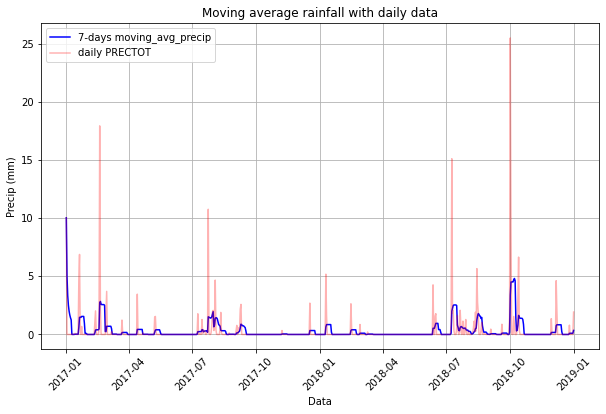

In [0]:
import matplotlib.pyplot as plt

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(df_pandas['date'], df_pandas['moving_avg_precip'], label='7-days moving_avg_precip', color='blue')
plt.plot(df_pandas['date'], df_pandas['PRECTOT'], label='daily PRECTOT', color='red', alpha=0.3)

# Tytuł i etykiety
plt.title('Moving average rainfall with daily data')
plt.xlabel('Data')
plt.ylabel('Precip (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Wyświetlenie wykresu
plt.show()

7. County 48245 in Texas has the largest weekly standard deviation of PRECTOT precipitation. Calculating how precipitation has varied from day to day in this county.

In [0]:
df_fips_48245 = weather.filter(weather.fips == 48245)

df_fips_48245.show(5)

+-----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+------+---------+---------------+
| fips|      date|PRECTOT|    PS|   TS|score|year|month|week|season|fips_padded|state_code| state|dry_spell|dry_spell_group|
+-----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+------+---------+---------------+
|48245|2017-01-01|   6.52|101.07|18.22| null|2017|    1|  52|Winter|      48245|        48|Teksas|        0|              1|
|48245|2017-01-02|  19.45|101.03|18.46| null|2017|    1|   1|Winter|      48245|        48|Teksas|        0|              2|
|48245|2017-01-03|   0.09|101.43|15.78|  0.0|2017|    1|   1|Winter|      48245|        48|Teksas|        0|              3|
|48245|2017-01-04|    0.0|101.73|12.43| null|2017|    1|   1|Winter|      48245|        48|Teksas|        1|              3|
|48245|2017-01-05|   0.82|101.24|14.22| null|2017|    1|   1|Winter|      48245|        48|Teksas|        0|              4|


In [0]:

windowSpec = Window.partitionBy("fips").orderBy("date").rowsBetween(-7, 0)  # 7 dni wstecz

df_fips_48245 = df_fips_48245.withColumn("moving_avg_precip", F.avg("PRECTOT").over(windowSpec))

df_fips_48245.show(5)

+-----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+------+---------+---------------+------------------+
| fips|      date|PRECTOT|    PS|   TS|score|year|month|week|season|fips_padded|state_code| state|dry_spell|dry_spell_group| moving_avg_precip|
+-----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+------+---------+---------------+------------------+
|48245|2017-01-01|   6.52|101.07|18.22| null|2017|    1|  52|Winter|      48245|        48|Teksas|        0|              1|              6.52|
|48245|2017-01-02|  19.45|101.03|18.46| null|2017|    1|   1|Winter|      48245|        48|Teksas|        0|              2|            12.985|
|48245|2017-01-03|   0.09|101.43|15.78|  0.0|2017|    1|   1|Winter|      48245|        48|Teksas|        0|              3| 8.686666666666666|
|48245|2017-01-04|    0.0|101.73|12.43| null|2017|    1|   1|Winter|      48245|        48|Teksas|        1|              3|            

In [0]:
df_pandas2 = df_fips_48245.select("date", "PRECTOT", "moving_avg_precip").toPandas()

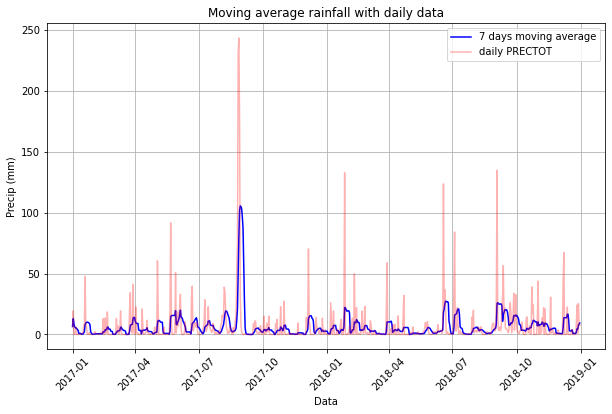

In [0]:

plt.figure(figsize=(10, 6))
plt.plot(df_pandas2['date'], df_pandas2['moving_avg_precip'], label='7 days moving average', color='blue')
plt.plot(df_pandas2['date'], df_pandas2['PRECTOT'], label='daily PRECTOT', color='red', alpha=0.3)


plt.title('Moving average rainfall with daily data')
plt.xlabel('Data')
plt.ylabel('Precip (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)


plt.show()

8. Calculate the total precipitation (PRECTOT) for each season in a given year and determine how total precipitation varied throughout the year depending on the season.

In [0]:
# Obliczanie sumy opadów na sezon w każdym roku i sortowanie wyników malejąco
df_seasonal_precip = weather.groupBy("fips", "state", "year", "season").agg(
    F.sum("PRECTOT").alias("seasonal_precip_sum")
)

# Sortowanie według 'seasonal_precip_sum' w malejącej kolejności
df_seasonal_precip_sorted = df_seasonal_precip.orderBy(F.col("seasonal_precip_sum"), ascending=False)

# Wyświetlanie wyników
df_seasonal_precip_sorted.select("fips", "state", "year", "season", "seasonal_precip_sum").show(3)

+-----+------+----+------+-------------------+
| fips| state|year|season|seasonal_precip_sum|
+-----+------+----+------+-------------------+
|48245|Teksas|2017|Summer|            1428.18|
|48167|Teksas|2017|Summer|            1338.15|
|48071|Teksas|2017|Summer| 1333.1800000000003|
+-----+------+----+------+-------------------+
only showing top 3 rows



The greatest rainfall totals occurred in the summer in the state of Texas.

In [0]:
9. Calculate the average precipitation (PRECTOT) for each season in a given year and determine how average precipitation varied between seasons.

In [0]:

df_seasonal_avg_precip = weather.groupBy("fips", "state", "year", "season").agg(
    F.avg("PRECTOT").alias("seasonal_precip_avg")
)

df_seasonal_avg_sorted = df_seasonal_avg_precip.orderBy(F.col("seasonal_precip_avg"), ascending=False)


df_seasonal_avg_sorted.select("fips", "state", "year", "season", "seasonal_precip_avg").show(3)

+-----+------+----+------+-------------------+
| fips| state|year|season|seasonal_precip_avg|
+-----+------+----+------+-------------------+
|48245|Teksas|2017|Summer| 15.523695652173913|
|48167|Teksas|2017|Summer| 14.545108695652175|
|48071|Teksas|2017|Summer| 14.491086956521743|
+-----+------+----+------+-------------------+
only showing top 3 rows



The highest average precipitation for a season was in county 28245 in Texas.

10. Identification of days with precipitation anomalies where precipitation anomalies occur, in which precipitation is greater than 3 standard deviations above the mean.

In [0]:
weather.show(3)

+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+
|fips|      date|PRECTOT|    PS|   TS| score|year|month|week|season|fips_padded|state_code|  state|dry_spell|dry_spell_group|
+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+
|1005|2017-01-01|  66.35|100.42|16.08|  null|2017|    1|  52|Winter|      01005|        01|Alabama|        0|              1|
|1005|2017-01-02|  47.72|100.47|18.35|  null|2017|    1|   1|Winter|      01005|        01|Alabama|        0|              2|
|1005|2017-01-03|   7.52| 99.91|16.52|0.6069|2017|    1|   1|Winter|      01005|        01|Alabama|        0|              3|
+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+
only showing top 3 rows



In [0]:

window_spec = Window.partitionBy("fips", "year").orderBy("date")

weather = weather.withColumn("mean_precip", F.avg("PRECTOT").over(window_spec))
weather = weather.withColumn("stddev_precip", F.stddev("PRECTOT").over(window_spec))

weather = weather.withColumn(
    "is_anomaly", F.when(F.abs(F.col("PRECTOT") - F.col("mean_precip")) > 3 * F.col("stddev_precip"), 1).otherwise(0)
)

weather.show(3)

+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+------------------+------------------+----------+
|fips|      date|PRECTOT|    PS|   TS| score|year|month|week|season|fips_padded|state_code|  state|dry_spell|dry_spell_group|       mean_precip|     stddev_precip|is_anomaly|
+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+------------------+------------------+----------+
|1005|2017-01-01|  66.35|100.42|16.08|  null|2017|    1|  52|Winter|      01005|        01|Alabama|        0|              1|             66.35|              null|         0|
|1005|2017-01-02|  47.72|100.47|18.35|  null|2017|    1|   1|Winter|      01005|        01|Alabama|        0|              2|            57.035|13.173399333505378|         0|
|1005|2017-01-03|   7.52| 99.91|16.52|0.6069|2017|    1|   1|Winter|      01005|        01|Alabama|        0|              3|

In [0]:

df_anomalies = weather.filter(F.col("is_anomaly") == 1)

df_anomalies.select("fips", "state","date", "PRECTOT", "mean_precip", "stddev_precip", "is_anomaly").show(3)

+----+-------+----------+-------+------------------+------------------+----------+
|fips|  state|      date|PRECTOT|       mean_precip|     stddev_precip|is_anomaly|
+----+-------+----------+-------+------------------+------------------+----------+
|1003|Alabama|2018-01-28|  28.32|3.1878571428571436|7.5952608796991194|         1|
|1003|Alabama|2018-02-10|  36.99| 4.017073170731708| 8.708996567889564|         1|
|1003|Alabama|2018-02-11|  44.47| 4.980238095238096|10.628242744892828|         1|
+----+-------+----------+-------+------------------+------------------+----------+
only showing top 3 rows



In [0]:

df_anomalies = df_anomalies.filter(F.col("is_anomaly") == 1)

df_anomalies_count = df_anomalies.groupBy("state").count()

df_anomalies_count = df_anomalies_count.orderBy(F.col("count").desc())

df_anomalies_count.show()

+-----------------+-----+
|            state|count|
+-----------------+-----+
|           Teksas| 6879|
|             Iowa| 3343|
|           Kansas| 3258|
|         Nebraska| 3080|
|         Wirginia| 3035|
|        Minnesota| 2964|
|          Georgia| 2684|
|         Missouri| 2623|
|         Kentucky| 2461|
|Karolina Północna| 2180|
|Dakota Południowa| 2074|
|        Wisconsin| 2012|
|         Illinois| 1990|
|        Tennessee| 1934|
|         Oklahoma| 1914|
|          Indiana| 1910|
|         Michigan| 1762|
|             Ohio| 1617|
|          Floryda| 1416|
|  Dakota Północna| 1360|
+-----------------+-----+
only showing top 20 rows



The most anomalies were in the state of Texas.

11. Detection of sudden temperature jumps (TS). Calculation of the temperature change (TS) from the previous day.

In [0]:

window_spec = Window.partitionBy("fips", "year", "season").orderBy("date")


weather = weather.withColumn("prev_temp", F.lag("TS").over(window_spec))
weather = weather.withColumn("temp_change", F.col("TS") - F.col("prev_temp"))


top_5_temp_changes = weather.orderBy(F.col("temp_change").desc()).limit(5)


top_5_temp_changes.select("fips", "date", "state", "TS", "prev_temp", "temp_change").show()

+-----+----------+-------+-----+---------+------------------+
| fips|      date|  state|   TS|prev_temp|       temp_change|
+-----+----------+-------+-----+---------+------------------+
|30041|2018-02-13|Montana|-7.13|   -25.64|             18.51|
|30005|2018-02-13|Montana| -7.2|   -24.96|             17.76|
|30051|2018-02-13|Montana|-6.56|   -23.83|             17.27|
|56023|2017-01-08|Wyoming| -3.8|   -20.33|16.529999999999998|
|30071|2018-02-13|Montana|-8.67|   -25.04|16.369999999999997|
+-----+----------+-------+-----+---------+------------------+



The largest jumps in soil temperature were in Montana

12. Removing NAN

In [0]:

df_cleaned = weather.dropna(subset=["score"])


df_cleaned.show()

+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+-------+---------------+---------+-------------------+
|fips|      date|PRECTOT|    PS|   TS| score|year|month|week|season|fips_padded|state_code|  state|dry_day|dry_spell_group|dry_spell|sum_30_days_PRECTOT|
+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+-------+---------------+---------+-------------------+
|1005|2017-01-03|   7.52| 99.91|16.52|0.6069|2017|    1|   1|Winter|      01005|        01|Alabama|      0|              3|        0| 121.58999999999999|
|1005|2017-01-10|   0.02|101.57| 5.73|0.5064|2017|    1|   2|Winter|      01005|        01|Alabama|      0|              7|        0|              143.5|
|1005|2017-01-17|   0.03|100.91|15.61|0.5064|2017|    1|   3|Winter|      01005|        01|Alabama|      0|             10|        0|0.09999999999999999|
|1005|2017-01-24|   0.02| 99.89| 9.83| 0.182|2017|    1|   4|Winter|      01

In [0]:

df_cleaned = df_cleaned.withColumn("score", F.col("score").cast("int"))

df_cleaned.show(3)

+----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+-------+-------+---------------+---------+-------------------+
|fips|      date|PRECTOT|    PS|   TS|score|year|month|week|season|fips_padded|state_code|  state|dry_day|dry_spell_group|dry_spell|sum_30_days_PRECTOT|
+----+----------+-------+------+-----+-----+----+-----+----+------+-----------+----------+-------+-------+---------------+---------+-------------------+
|1005|2017-01-03|   7.52| 99.91|16.52|    0|2017|    1|   1|Winter|      01005|        01|Alabama|      0|              3|        0| 121.58999999999999|
|1005|2017-01-10|   0.02|101.57| 5.73|    0|2017|    1|   2|Winter|      01005|        01|Alabama|      0|              7|        0|              143.5|
|1005|2017-01-17|   0.03|100.91|15.61|    0|2017|    1|   3|Winter|      01005|        01|Alabama|      0|             10|        0|0.09999999999999999|
|1005|2017-01-24|   0.02| 99.89| 9.83|    0|2017|    1|   4|Winter|      01005|   

13. Counting how many score occurrences there are in each class

In [0]:

df_class_count = df_cleaned.groupBy("score").count()


df_class_count.show()

+-----+------+
|score| count|
+-----+------+
|    1| 48310|
|    3|  8732|
|    5|   307|
|    4|  2713|
|    2| 21025|
|    0|242145|
+-----+------+



14. Counting in which state class 4 and 5 appears most often

In [0]:

filtered_df = df_cleaned.filter((F.col("score") == 4) | (F.col("score") == 5))

df_score_grouped = filtered_df.groupby("fips", "year", "score").count()

df_with_state = df_score_grouped.join(df_cleaned.select("fips", "state").distinct(), on="fips", how="left")

top_10_df = df_with_state.orderBy(F.desc("count")).limit(10)

top_10_df.select("fips", "state", "year", "score", "count").show()

+-----+-----------+----+-----+-----+
| fips|      state|year|score|count|
+-----+-----------+----+-----+-----+
| 8023|   Kolorado|2018|    4|   40|
|35028|Nowy Meksyk|2018|    4|   40|
|35039|Nowy Meksyk|2018|    4|   40|
|35055|Nowy Meksyk|2018|    4|   40|
| 8021|   Kolorado|2018|    4|   36|
| 8113|   Kolorado|2018|    4|   36|
| 8003|   Kolorado|2018|    4|   36|
|35031|Nowy Meksyk|2018|    4|   36|
| 8105|   Kolorado|2018|    4|   36|
|35007|Nowy Meksyk|2018|    4|   36|
+-----+-----------+----+-----+-----+



15. DataFrame weather and soil connection based on column 'fips' and 'date'

In [0]:

df_combined = weather.join(soil, on=["fips"], how="inner")


df_combined.show()

+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+--------+----------+--------+--------+--------+--------+--------+-----------+-----------+---------+
|fips|      date|PRECTOT|    PS|   TS| score|year|month|week|season|fips_padded|state_code|  state|dry_spell|dry_spell_group|     lat|       lon|WAT_LAND|NVG_LAND|URB_LAND|GRS_LAND|FOR_LAND|CULTRF_LAND|CULTIR_LAND|CULT_LAND|
+----+----------+-------+------+-----+------+----+-----+----+------+-----------+----------+-------+---------+---------------+--------+----------+--------+--------+--------+--------+--------+-----------+-----------+---------+
|1005|2017-01-01|  66.35|100.42|16.08|  null|2017|    1|  52|Winter|      01005|        01|Alabama|        0|              1|31.87067|-85.405456|     0.0|     0.0|     0.4|     2.2|    23.0|       72.6|        1.8|     74.4|
|1005|2017-01-02|  47.72|100.47|18.35|  null|2017|    1|   1|Winter|      01005|        01|Alabama| 